### **Эксперимент 5.**

Рассчитать приведенную температуру (через egt, tat, ... theta) и n1. Отбросить `egt, tat, n1, XF, HPV, NF`.

Использовать конфигурацию эксперимента 4. 

Сохранить и записать использованные константы.

Note: выяснилось, что если убрать NF то качество сильно падает. разобраться, почему

In [1]:
import pandas as pd

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']


In [2]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

In [3]:
bgu.head(3)

,reportts,acnum,pos,egtm,fltdes,dep,arr,ivs12,ibe,iaie,...,votm,vsva,w14,pf,wai,nai,prv,hpv,xf,reason
0,2018-12-24 10:53:22,VQ-BGU,1,44.437,8990.0,EDHI,UUDD,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
1,2018-12-25 15:23:23,VQ-BGU,1,44.379,1024.0,URSS,UUDD,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
2,2018-12-25 20:49:27,VQ-BGU,1,43.742,217.0,UUDD,UNBB,NaN,NaN,NaN,...,NaN,0.0,1302.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN


#### Подготовка

In [4]:
from utils import *

data = build_dataset(
  [bgu, bdu], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model(X, y, model = 'linreg', alpha=0.2):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = LinearRegression()

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)
  r2 = r2_score(y_test, predicted_test)

  return mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test

In [6]:
import matplotlib.pyplot as plt

# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=1/10), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=1/10), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

#### Baseline из эксперимента 4

In [7]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

In [8]:
mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: rmse = {mse:.3f} mae = {mae:.3f} r2 = {r2:.3f}')


Baseline: rmse = 1.770 mae = 1.451 r2 = 0.439


#### Коррекция

In [9]:
def correct(data):
  alpha = 0.5
  theta = (data['tat'] + 273.15) / 288.15

  # data['n1k'] = data['n1a'] / (theta ** alpha)
  # data['n2k'] = data['n2a'] / (theta ** alpha)
  data['egtk'] = (data['egt'] + 273.15) / theta

  return data


In [10]:
features = ['egtk', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

In [11]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: rmse = {mse:.3f} mae = {mae:.3f} r2 = {r2:.3f}')


Baseline: rmse = 1.610 mae = 1.324 r2 = 0.536


Wow, just the egt correction gained us 0.1 increase in R squared!

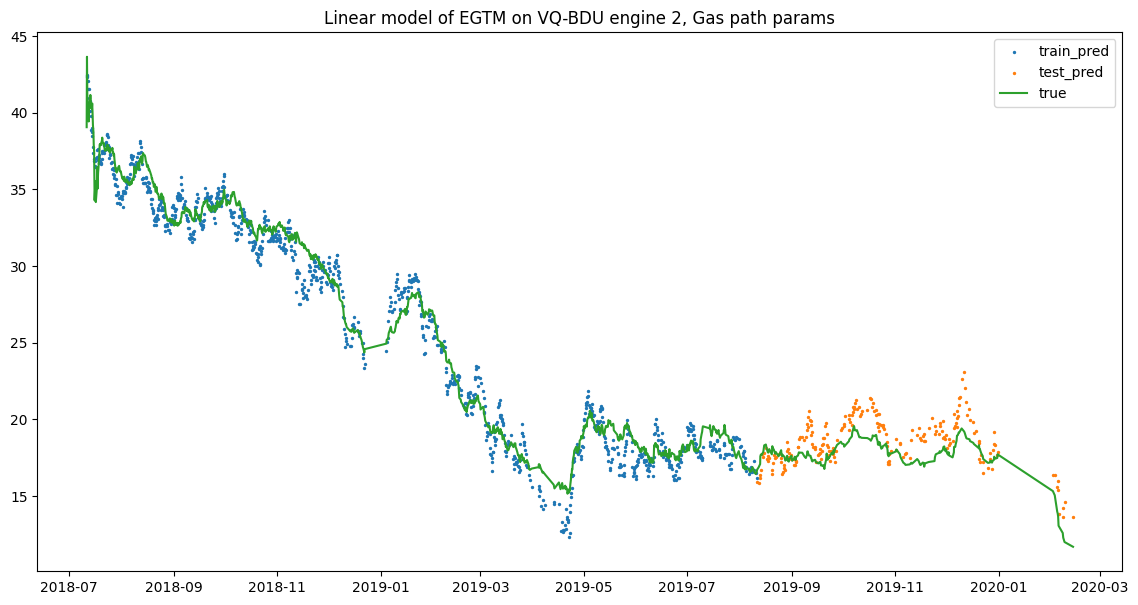

In [12]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=False)

In [13]:
features = ['egtk', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: rmse = {mse:.3f} mae = {mae:.3f} r2 = {r2:.3f}')

Baseline: rmse = 1.610 mae = 1.324 r2 = 0.536


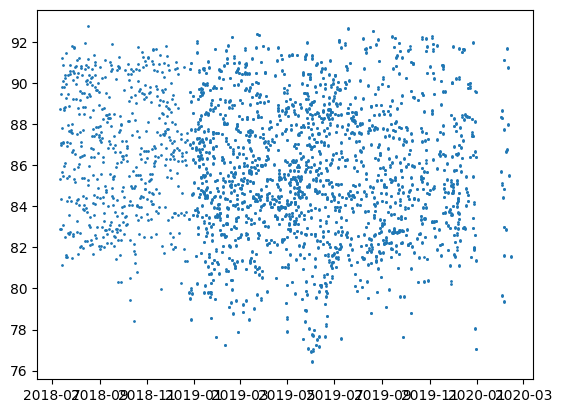

In [14]:
theta = (data['tat'] + 273.15) / 288.15

alpha = 0.5

data['n1k'] = data['n1a'] / (theta ** alpha)
data['n2k'] = data['n2a'] / (theta ** alpha)
# data['egtk'] = (data['egt'] + 273.15) / theta
plt.scatter(data['reportts'], data['n1k'], s=1)